# Evaluate B1, C1, D1 models

Based on pix2pix/test.py and A1_eval notebook

In [1]:
from thirdparty.pix2pix.options.test_options import TestOptions
from thirdparty.pix2pix.data import create_dataset
from thirdparty.pix2pix.models import create_model
from thirdparty.pix2pix.util import util
from tqdm import tqdm
import torch
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import StructuralSimilarityIndexMeasure
import IPython.display as display
from IPython.display import HTML
from PIL import Image

import common_functions as core

In [2]:
# Model information

model_direction = core.B1.direction

b1_model_name = core.B1.name
b1_merged_dataset_location = core.get_path(core.B1.prepared_data_dir, "combined")

c1_model_name = core.C1.name
c1_merged_dataset_location = core.get_path(core.C1.prepared_data_dir, "combined")

d1_model_name = core.D1.name
d1_merged_dataset_location = core.get_path(core.D1.prepared_data_dir, "combined")

model_type = core.B1.model_type

In [3]:
def load_model_dataset(merged_dataset_location, model_name, phase="test"):
    """
    Function to load a model and dataset
    :param merged_dataset_location: location of 'combined' dataset for model
    :param model_name: name of model
    :param phase: load 'test'/'train'/'val' data
    :return: loaded model and dataset to use for evaluation
    """
    # Arguments for Pix2Pix TestOptions
    args = ["--dataroot", merged_dataset_location, "--name", model_name, "--model", model_type, "--direction", model_direction, "--phase", phase, "--netG", "unet_64", "--netD", "pixel", "--load_size", "64", "--crop_size", "64", "--display_winsize", "64"]
    
    # Parsed test options
    opt = TestOptions().parse(args)
    opt.num_threads = 0
    opt.batch_size = 1
    opt.serial_batches = True
    opt.no_flip = True
    opt.display_id = -1
    dataset = create_dataset(opt)
    model = create_model(opt)
    model.setup(opt)
    
    return model, dataset

In [4]:
def show_image(img):
    """
    Function to display an image
    :param img: tensor
    """
    # Convert tensor to image
    im = util.tensor2im(img)
    im = Image.fromarray(im)
    # Display image in notebook
    display.display(im)

def show_html(html):
    """
    Function to display HTML string in notebook
    :param html: html string
    """
    display.display(HTML(html))

def image_to_rgb(img):
    """
    Function to convert an image to RGB
    Code derived from Pix2Pix code
    :param img: tensor with float values to represent image
    :return: tensor with RGB integer values
    """
    n = img[0].cpu().float().numpy()
    converted = ((n + 1) / 2.0 * 255.0).astype(np.uint8)
    return torch.from_numpy(converted)

In [5]:
def evaluate_model(model_name, model, dataset, phase="test"):
    """
    Function to evaluate a model
    :param model_name: name of model
    :param model: model object
    :param dataset: dataset object
    :param phase: test/train/val
    """
    # Metrics objects for evaluation
    fid = FrechetInceptionDistance(feature=64, input_img_size=(3, 64, 64))
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
    
    ground_truth_data = []
    generated_data = []
    
    # Display header in notebook
    show_html(f"<h3>Evaluating {model_name} model with {phase} dataset</h3>")
    
    # For loop to test model and get ground truth images and generated images
    # Derived from Pix2Pix code
    # FID: https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html
    # SSIM: https://lightning.ai/docs/torchmetrics/stable/image/structural_similarity.html
    for i, datum in enumerate(tqdm(dataset)):
        model.set_input(datum)
        # Pix2Pix model testing
        model.test()
        visuals = model.get_current_visuals()
        generated = visuals['fake_B']
        ground_truth = visuals['real_B']
        
        # Show first image
        if i == 0:
            show_html("<b>Input Sketch</b>")
            show_image(visuals['real_A'])
            show_html("<b>Generated Image</b>")
            show_image(generated)
            show_html("<b>Ground Truth Image</b>")
            show_image(ground_truth)
    
        # Add fake and real images to arrays
        generated_data.append(image_to_rgb(generated))
        ground_truth_data.append(image_to_rgb(ground_truth))
    
    # Pass in real and generated images to metrics objects
    fid.update(torch.stack(ground_truth_data), real=True)
    fid.update(torch.stack(generated_data), real=False)
    ssim.update(torch.stack(generated_data).float() / 255.0, torch.stack(ground_truth_data).float() / 255.0)
    
    # Calculating FID and SSIM scores and display them
    fid_score = fid.compute().item()
    ssim_score = ssim.compute().item()
    show_html(f"<span style='color: orange'><b>FID score = {fid_score}</b></span>")
    show_html(f"<span style='color: cyan'><b>SSIM score = {ssim_score}</b></span>")

# B1 evaluation

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 64                            	[default: 256]
                 dataroot: /Users/tashvit/Documents/GitHub/mmpixagen/datasets/model_b_data/combined/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 64                            	[default: 256]
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         

  0%|          | 0/99 [00:00<?, ?it/s]

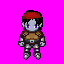

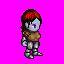

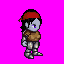

100%|██████████| 99/99 [00:04<00:00, 22.41it/s]


In [6]:
# -------- Evaluate B1 with test dataset ------------

model, dataset = load_model_dataset(b1_merged_dataset_location, b1_model_name, phase="test")
evaluate_model('B1', model, dataset, phase="test")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 64                            	[default: 256]
                 dataroot: /Users/tashvit/Documents/GitHub/mmpixagen/datasets/model_b_data/combined/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 64                            	[default: 256]
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         

  0%|          | 0/721 [00:00<?, ?it/s]

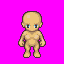

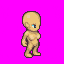

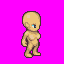

100%|██████████| 721/721 [00:11<00:00, 64.26it/s]


In [7]:
# -------- Evaluate B1 with train dataset ------------

model, dataset = load_model_dataset(b1_merged_dataset_location, b1_model_name, phase="train")
evaluate_model('B1', model, dataset, phase="train")

# C1 evaluation

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 64                            	[default: 256]
                 dataroot: /Users/tashvit/Documents/GitHub/mmpixagen/datasets/model_c_data/combined/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 64                            	[default: 256]
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         

  0%|          | 0/99 [00:00<?, ?it/s]

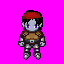

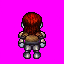

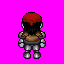

100%|██████████| 99/99 [00:01<00:00, 63.65it/s]


In [8]:
# -------- Evaluate C1 with test dataset ------------

model, dataset = load_model_dataset(c1_merged_dataset_location, c1_model_name, phase="test")
evaluate_model('C1', model, dataset, phase="test")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 64                            	[default: 256]
                 dataroot: /Users/tashvit/Documents/GitHub/mmpixagen/datasets/model_c_data/combined/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 64                            	[default: 256]
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         

  0%|          | 0/721 [00:00<?, ?it/s]

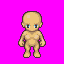

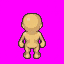

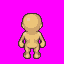

100%|██████████| 721/721 [00:11<00:00, 63.85it/s]


In [9]:
# -------- Evaluate C1 with train dataset ------------

model, dataset = load_model_dataset(c1_merged_dataset_location, c1_model_name, phase="train")
evaluate_model('C1', model, dataset, phase="train")

# D1 evaluation

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 64                            	[default: 256]
                 dataroot: /Users/tashvit/Documents/GitHub/mmpixagen/datasets/model_d_data/combined/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 64                            	[default: 256]
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         

  0%|          | 0/99 [00:00<?, ?it/s]

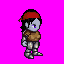

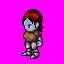

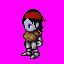

100%|██████████| 99/99 [00:01<00:00, 65.55it/s]


In [10]:
# -------- Evaluate D1 with test dataset ------------

model, dataset = load_model_dataset(d1_merged_dataset_location, d1_model_name, phase="test")
evaluate_model('D1', model, dataset, phase="test")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 64                            	[default: 256]
                 dataroot: /Users/tashvit/Documents/GitHub/mmpixagen/datasets/model_d_data/combined/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 64                            	[default: 256]
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         

  0%|          | 0/721 [00:00<?, ?it/s]

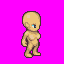

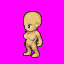

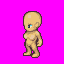

100%|██████████| 721/721 [00:11<00:00, 61.74it/s]


In [11]:
# -------- Evaluate D1 with train dataset ------------

model, dataset = load_model_dataset(d1_merged_dataset_location, d1_model_name, phase="train")
evaluate_model('D1', model, dataset, phase="train")